<a href="https://colab.research.google.com/github/ali7amie/Tianlai-M2-Internship-/blob/master/source_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!git clone https://github.com/ali7amie/Tianlai-M2-Internship-.git
%cd /content/Tianlai-M2-Internship-/


!pip install photutils
!pip install healpy
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
import scipy.ndimage as nd
import numpy.ma as ma
import pandas as pd

Cloning into 'Tianlai-M2-Internship-'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 231 (delta 41), reused 81 (delta 30), pack-reused 138
Receiving objects: 100% (231/231), 16.63 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/Tianlai-M2-Internship-
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 826 kB 31.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.7 MB 1.4 MB/s 


# Introduction

# Simulating sky maps

## Simulating with Python

These maps simulate observed images regardless of radio interferometry observation specificity. Each map results from adding white gaussian noise background to a set of unresolved sources distributed randomly. Assuming a gaussian beam (PSF), sources have perfect gaussian shapes. Maps are constructed as the following:

1. Build a gaussian prototype for sources with known size, amplitude in kelvin, standard deviation, and total flux density in jansky
2. Add the sources population to the noisy background

In [ ]:
import k2jansky

def create_gaussian_src(src_size,src_std,src_flux_jansky):
    # create a source with amplitude of 1 k
    x,y = np.meshgrid(np.linspace(-(src_size//2),src_size//2,src_size),np.linspace(-(src_size//2),src_size//2,src_size))
    mean_x=0
    mean_y=0
    src=np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))
    flux_kelvin_of_1k_amplitude=np.sum(src)
    flux_jansky_of_1k_amplitude=k2jansky.k2jansky('freq',1300*10**6,16.5,1,flux_kelvin_of_1k_amplitude)
    # add the src_flux_jansky factor
    src=(src_flux_jansky/flux_jansky_of_1k_amplitude)*np.exp(-(x-mean_x)**2/(2*src_std**2)) * np.exp(-(y-mean_y)**2/(2*src_std**2))
    return src

d=create_gaussian_src(5,1.1,1)



    

...

In [ ]:


import create_gaussian_src



def create_map(map_size,src_number,src_size,src_std,src_flux_jansky,noise_std):
    """ This function create a map as a 2D Numpy array, enter map_size,src_number,src_size,src_std,src_flux_jansky,noise_std"""

    #create empty map
    rectmap=np.zeros((map_size,map_size))

    #create a gaussian source
    src=create_gaussian_src.create_gaussian_src(src_size,src_std,src_flux_jansky)

    #add src_number source to with random position, but with 2*src_size distant from the boundary.
    x=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number)
    y=np.random.random_integers(low=2*src_size,high=map_size-2*src_size,size=src_number) #generate random position, note that x and y here represent a matrix like coordinate, so the number of column or absice is y, the number of row or ordonnée is x
    
    for i in range(0,len(x)):
            rectmap[y[i]-(src_size//2):y[i]+((src_size//2)+1),x[i]-(src_size//2):x[i]+((src_size//2)+1)]=src
    
    #add gaussian noise
    noise =  make_noise_image((map_size,map_size), distribution='gaussian', mean=0,stddev=noise_std)
    rectmap=rectmap+noise
    catalog=np.transpose((y,x,src_flux_jansky*np.ones_like(x)))#upper pix_center, pix center to index. pix corner ??? plot??    
    return (rectmap,catalog)

simulation=create_map(50,10,5,1.1,1,0.001)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead


## JSKyMap software's Simulations

These maps simulate the transit observation procedure of radio interferometry. JSkyMap simulates all visibilities of the interferometer, defined as the mean of the correlation of two dish feeds, and uses them to compute full sky maps in spherical geometry. 

JSkyMap is written in C++ and uses the SOPHYA class library.

1. Install SOPHYA
2. Install JSkyMap

We will use Shell to execute JSkyMap commands

**INCOMPLETE**


In [ ]:
set JEXE=$JSKYBASE/Objs
set NCPDECPOINT=90,88,86,84
set FREQ=1300
set SETUPF = seven_setup.d
set NSIDE = 256
set LMAX = 700
set BEAMFILE = beam_autoon_{$FREQ}_4dec_double.ppf
set AINV = inv_autoon_{$FREQ}_4dec_double.ppf
set INMAP = haslam1300eq.fits 
set SIGMAELL = 450
set SRCFILE = srctxt_{$FLUX}jansky_iteration{$ITERATION}.txt
set VISFILE = vis_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.ppf
set OUTMAPF = map_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits
set RECALMFILE=map_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits
set FILTMAPFILE=filtmap_ncp_autoon_{$NOISE}_{$FREQ}_{$FLUX}_{$ITERATION}_4dec.fits


$JEXE/map2vis -sharp -setup $SETUPF -pdec $NCPDECPOINT -freq $FREQ -healpix $NSIDE -lmax $LMAX -nthreads 10,16 -mxprod blas,4 -ngb -in $INMAP -src $SRCFILE -out $VISFILE 
$JEXE/p4src2vis -setup $SETUPF -src $SRCFILE -freq $FREQ -noise $NOISE -ram 1 -healpix $NSIDE -pdec $NCPDECPOINT -ngb -out $VISFILE 
$JEXE/vis2map -freq $FREQ -lmax $LMAX -noise $NOISE -rdbeam $BEAMFILE -rdainv $AINV -healpix $NSIDE -psithr 0.02,0.001 -nthreads 8,6 -ngb -prt 2 -sharp -mxprod blas,4 $SETUPF $VISFILE visarr_ $NCPDECPOINT $OUTMAPF  
$JEXE/filt2map -lmax $LMAX -healpix $NSIDE -gaussfilt $SIGMAELL -fmlow 1 $RECALMFILE $FILTMAPFILE 

Ellipsis

# Source finder

### Input map

#### Maps made with JSKyMap

The final output of JSkyMap consists of a full sky map in spherical geometry pixelated according to HEALPix and loaded in a FITS file. This step of the source finder uses the HealPy package to perform the following task:
1. read the fits file 
2. load the data in NumPy arrays, where a temperature is assigned to each HEALPix pixel
3. crop a gnomonic projection of the observed zone (North Celestial Pole). Thus, the new projection consists of a new NumPy array that assigns a temperature to new square pixels. **The size of the observation pixel, the HEALPix pixel size, and the gnomonic square pixel size are tightly related**








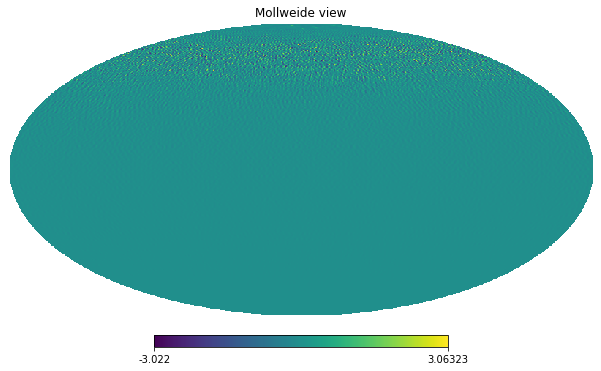

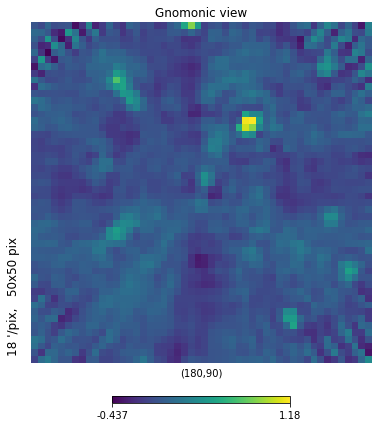

In [ ]:

def fits2map(fits_filename,map_size, map_resolution, projection_center):

  ''' This function take a fits file, convert it into full spherical sky map,
   and return a gnomonic projection around a given point 

   fits_filename : str
                   FITS file name

   map_size : int
              the side length in pixels of of the square gnomonic map

   map_resolution : int
                    map resolution in arcminutes

   projection_center : tuple
                       (longitude, latitude) the coordinate of the projection center in degrees '''

  #convert the fits file into healpix pixelized full sky map
  full_map = hp.read_map(fits_filename,dtype = None)

  #display a mollweide projection
  spherical_map = hp.mollview(full_map,return_projected_map = True)#, no_plot = True)

  #crop a gnomonic view at NCP
  rectmap = hp.gnomview(full_map,rot=[projection_center[0],projection_center[1]],reso = map_resolution,xsize = map_size,ysize = map_size,return_projected_map = True)#, no_plot = True)
  

  return (rectmap,[0,0])

JS_simulation = fits2map("filtmap_ncp_autoon_0.001_1300_0.075_0_4dec.fits",50,18,(180,90))



#### Maps made with python

Here the input map already consists of a square map and there is no additional task to do. Its size and resolution mimic gnomonic projections of spherical maps.

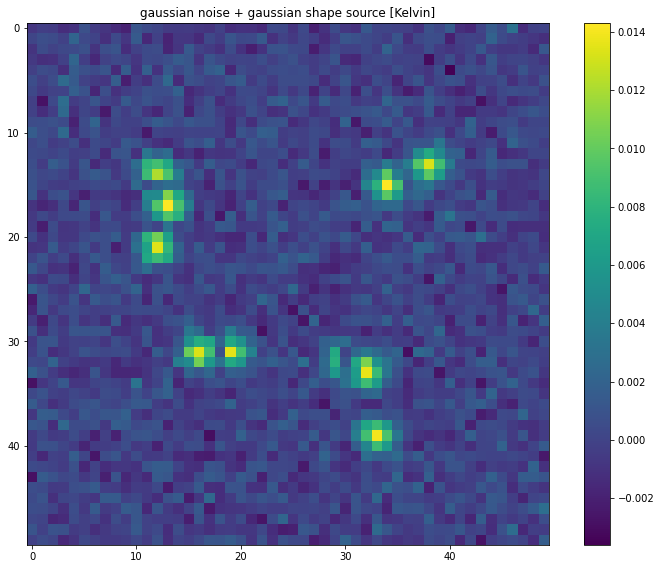

,vertical coor[pixel],horizontal coor[pixel],flux[Jy]
0,21,12,1
1,15,34,1
2,32,30,1
3,39,33,1
4,33,32,1
5,14,12,1
6,31,19,1
7,13,38,1
8,17,13,1
9,31,16,1


In [ ]:

rectmap=simulation[0]
simulated_catalog=simulation[1]

plt.figure(figsize=[12.8, 9.6])
plt.imshow(rectmap)
plt.colorbar()
plt.title('gaussian noise + gaussian shape source [Kelvin]')
plt.show()


simulation_dataframe=pd.DataFrame(simulated_catalog,columns=['vertical coor[pixel]','horizontal coor[pixel]','flux[Jy]'])
simulation_dataframe

### Global background estimation

In [ ]:
def rectmap_statistics(rectmap):
    return(np.median(rectmap),np.std(rectmap))

global_stat=rectmap_statistics(rectmap)    
global_stat

(8.719673431907948e-05, 0.0018327637533444025)

### Building a set of detection kernels

Creating the kernels and detection tools before execute the detection criteria
<br>
we used three kernels : cental, intermediate, and peripheric <br> (**could be made with open CV???**)

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 1)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


def create_kernels(detection_kernels_size):


    ''' This function take the size of kernels and give the kernels 

    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''


    #create the central kernel
    normalization1 = 1/detection_kernels_size[0]**2
    central_kernel = normalization1 * np.ones((detection_kernels_size[0],detection_kernels_size[0]))

    #create intermediate kernel
    normalization2 = 1/(detection_kernels_size[1]**2 - detection_kernels_size[0]**2)
    intermediate_kernel = normalization2 * np.pad(0*central_kernel,int((detection_kernels_size[1]-detection_kernels_size[0])/2),pad_with)

    #create peripherical kernel
    normalization3 = 1/(detection_kernels_size[2]**2 - detection_kernels_size[1]**2)
    peripherical_kernel = normalization3 * np.pad(0*intermediate_kernel,int((detection_kernels_size[2]-detection_kernels_size[1])/2),pad_with)

    
    
    
    return (central_kernel, intermediate_kernel, peripherical_kernel)
    
detection_kernels_size=(3,5,7)
kernels=create_kernels(detection_kernels_size)




### Create convolution maps

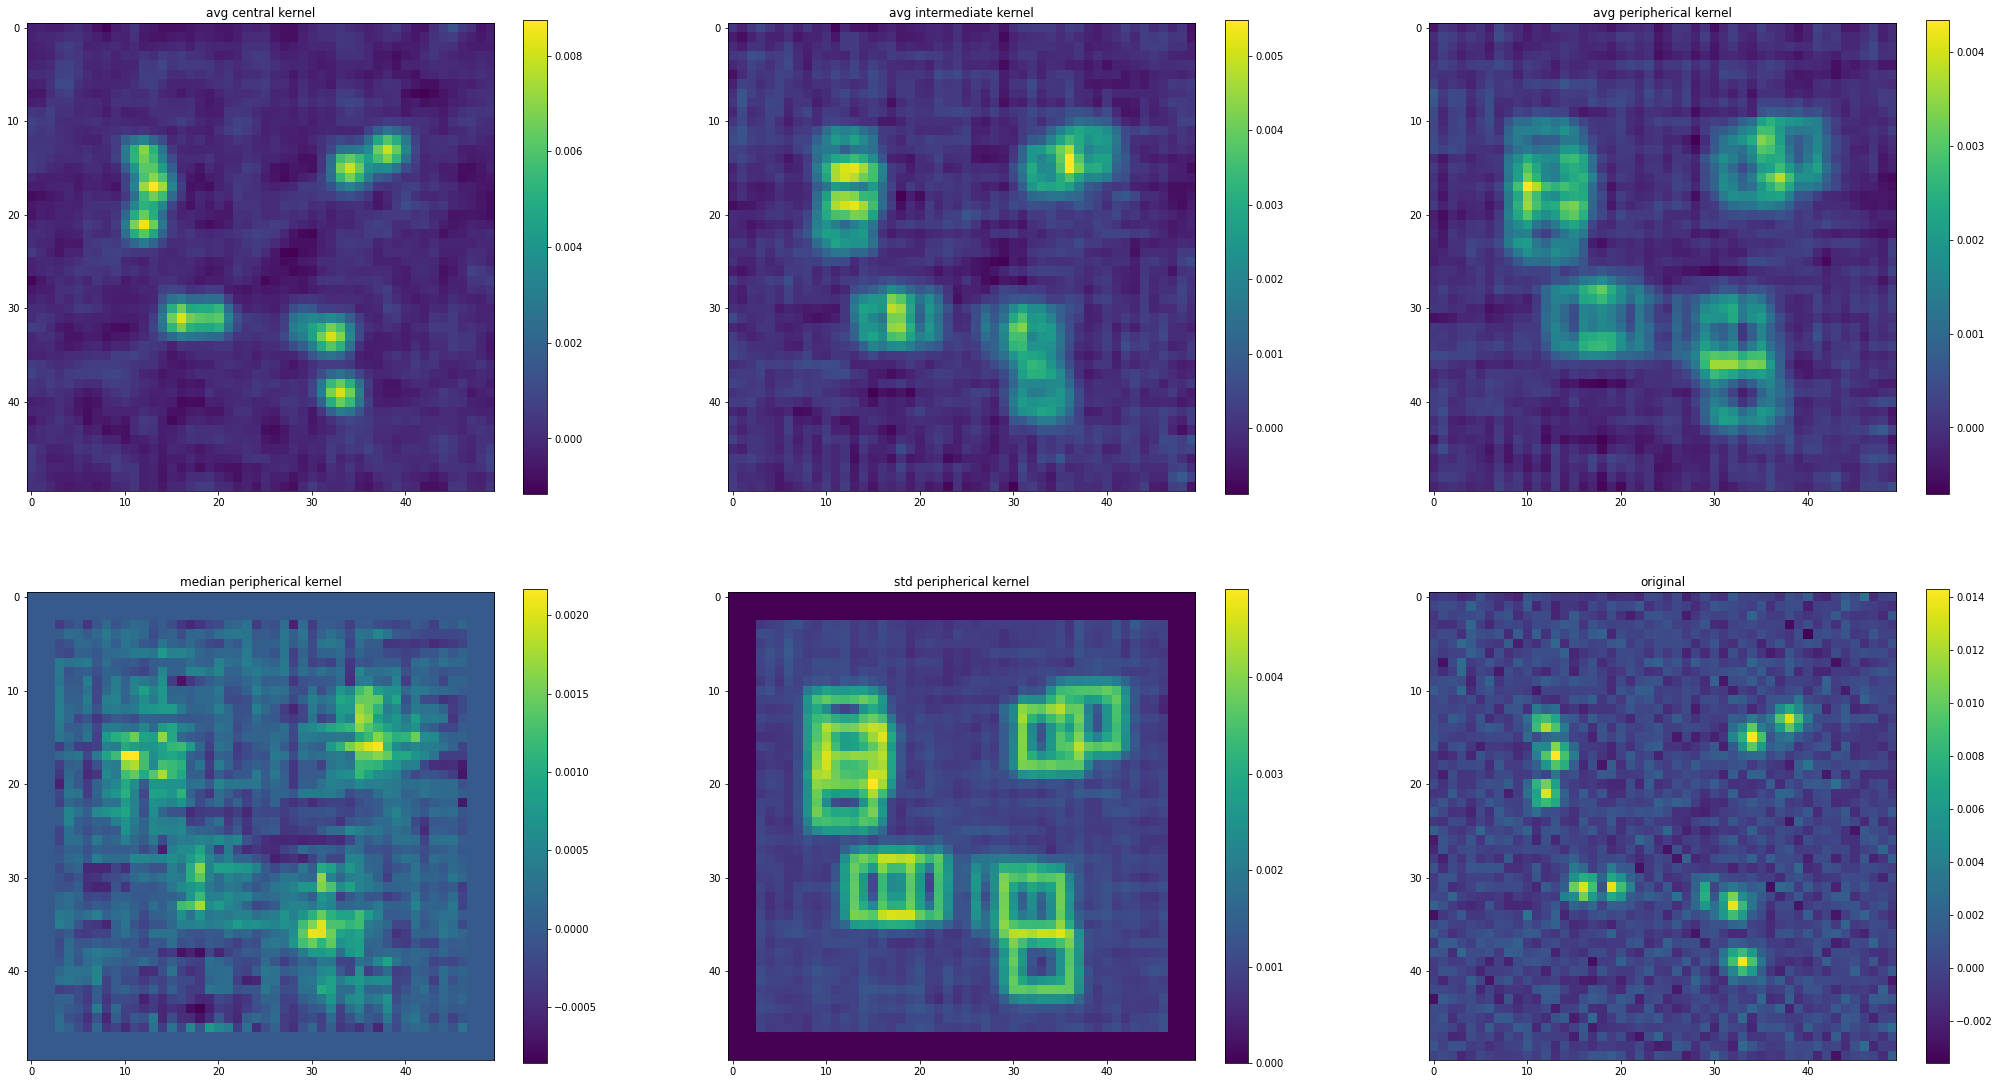

In [ ]:
def create_conv_maps(kernels,detection_kernels_size,rectmap):


    ''' This function take three kernels and give convolution maps 

    kernels: tuple
             (central kernel (ndarray), intermediate kernel (ndarray), peripherical kernel (ndarray))
             
    detection_kernels_size: tuple
                            (size of central kernel, size of intermediate kernel, size of peripherical kernel) '''

    central_kernel_map=nd.convolve(rectmap,kernels[0])
    intermediate_kernel_map=nd.convolve(rectmap,kernels[1])
    peripherical_kernel_map=nd.convolve(rectmap,kernels[2])


    # an additional kernel wich compute median and std maps (local background)   
    peripheric_median_map=np.zeros_like(rectmap)
    peripheric_std_map = np.zeros_like(rectmap)
    mask=np.array(kernels[2]==0)
    for i in range(int(detection_kernels_size[2]/2),rectmap.shape[0]-int(detection_kernels_size[2]/2)):
        for j in range(int(detection_kernels_size[2]/2),rectmap.shape[1]-int(detection_kernels_size[2]/2)):
            if (detection_kernels_size[2]/2).is_integer()==False:
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+(int(detection_kernels_size[2]/2)+1),j-int(detection_kernels_size[2]/2):j+(int(detection_kernels_size[2]/2)+1)]
                    
            else:
                    
                kernel=rectmap[i-int(detection_kernels_size[2]/2):i+int(detection_kernels_size[2]/2),j-int(detection_kernels_size[2]/2):j+int(detection_kernels_size[2]/2)]
                    
            masked_kernel=ma.masked_array(kernel,mask)
            peripheric_std_map[i][j]=np.ma.std(masked_kernel)
            peripheric_median_map[i][j]=np.ma.median(masked_kernel)

    return (central_kernel_map,intermediate_kernel_map,peripherical_kernel_map,peripheric_median_map,peripheric_std_map)       

conv_maps=create_conv_maps(kernels,detection_kernels_size,rectmap)

plt.figure(figsize=[35.6, 19.2])
title=['avg central kernel','avg intermediate kernel','avg peripherical kernel','median peripherical kernel','std peripherical kernel']
for i in range(0,len(conv_maps)):
   
    plt.subplot(231+i)
    plt.imshow(conv_maps[i])
    plt.title(title[i])
    plt.colorbar()

plt.subplot(231+i+1)
plt.imshow(rectmap)
plt.title('original') 
plt.colorbar()   

plt.show()


### Apply the detection criteria

Now we have the detection kernels <br> we conduct a detection criteria: a pixels belong to a potential source if: avg(central_kernel)>local_bg+n*local_std

This step output a list of pixels that are said to belong to potential sources. We should sort these pixels into sources. We sort pixels by their S/N ratio and then merge them hierarchically. We set a threshold of temperature, and assign other pixels inside an aperture to the targeted one.

1. set the detection criteria
2. applying it to each pixel on the map
3. we recieve a list of pixel that belong to sources
4. sort pixels by their S/N ratio as the begin of hierarchical merging


In [187]:
def detection(conv_maps,n):

     ''' This function take convolution maps, manipulate them within detection criteria, 
     and return list of pixels that belong to potential sources and their amplitude. It is sorted by the S/N ratio

    conv_maps: tuple
               (avg central map (ndarray), avg intermediate map (ndarray), avg peripherical map (ndarray), median peripherical map (ndarray), std peripherical map (ndarray))
             
    n: int
       The detection threshold '''


     threshold = conv_maps[3] + n * global_stat[1] 
     first_condition = conv_maps[0] >= threshold 
     detected_src_coor_upper_pixcorner = np.where( first_condition )  #this list of coordinate are in the upper system (vertical from top, horizontal from left) and each pixel is localized by its corner
     signal = rectmap[detected_src_coor_upper_pixcorner]
     local_bg = conv_maps[3][detected_src_coor_upper_pixcorner] 
     local_bg_std = conv_maps[4][detected_src_coor_upper_pixcorner] 
     signal_to_noise = signal/local_bg_std
     raw_detected_pix=np.column_stack((detected_src_coor_upper_pixcorner[0],detected_src_coor_upper_pixcorner[1],signal,local_bg,local_bg_std,signal_to_noise,np.zeros(len(signal))))
     raw_detection = pd.DataFrame(raw_detected_pix,columns=['vertical coor','horizontal coor','Amplitude [K]','Local median','Local std','S/N','Flag'])
     sorter=np.flip(np.argsort(raw_detection['S/N']))
     sorted_raw_detection = raw_detection.iloc[sorter]
     return sorted_raw_detection

sorted_raw_detection = detection(conv_maps,1)
sorted_raw_detection







,vertical coor,horizontal coor,Amplitude [K],Local median,Local std,S/N,Flag
132,39.0,33.0,0.013986,-0.000255,0.000746,18.746087,0.0
86,31.0,15.0,0.010245,0.000330,0.001130,9.067615,0.0
136,40.0,33.0,0.008641,-0.000011,0.000969,8.916735,0.0
71,22.0,12.0,0.008618,-0.000047,0.001016,8.483826,0.0
17,13.0,39.0,0.008835,0.000751,0.001237,7.141037,0.0
...,...,...,...,...,...,...,...
59,19.0,11.0,0.001014,0.001420,0.003859,0.262809,0.0
73,23.0,12.0,0.000743,-0.000122,0.002969,0.250341,0.0
32,15.0,11.0,0.000460,0.001488,0.003211,0.143158,0.0
95,31.0,30.0,0.000093,0.000738,0.002904,0.032047,0.0


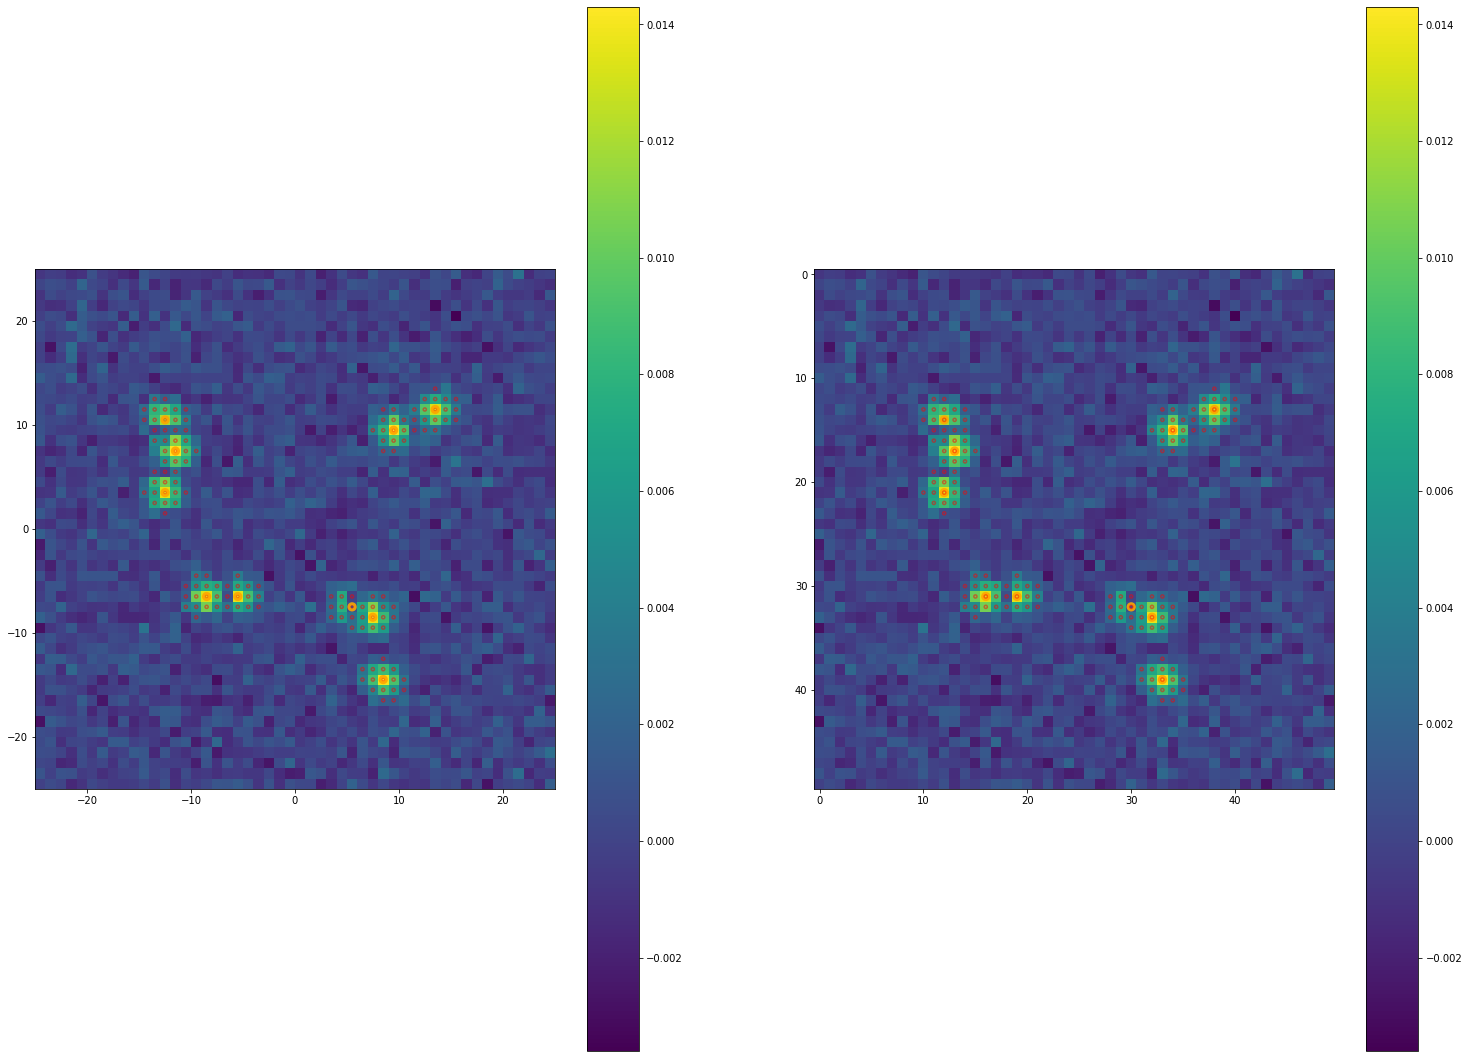

In [167]:
import matplotlib.pyplot as plt

from photutils.aperture import CircularAperture

import convert_map_index

simulated_coor_center=convert_map_index.convert_upper_to_center( [ simulated_catalog[:,0],simulated_catalog[:,1] ] , np.shape(rectmap)[0],len(simulated_catalog[:,0]) )[4]
coor_center=convert_map_index.convert_upper_to_center([sorted_raw_detection['vertical coor'],sorted_raw_detection['horizontal coor']],np.shape(rectmap)[0],len(sorted_raw_detection['vertical coor']))[4]


    
detected_pixels_center = CircularAperture(coor_center, r=0.15)
detected_pixels_upper = CircularAperture(np.transpose((sorted_raw_detection['horizontal coor'],sorted_raw_detection['vertical coor'])), r=0.15)


simulated_src_center=CircularAperture(simulated_coor_center, r=0.3)
simulated_src_upper=CircularAperture(np.transpose((simulated_catalog[:,1],simulated_catalog[:,0])), r=0.3)


    
plt.figure(figsize=[25.6, 19.2])

plt.subplot(121)
plt.imshow(rectmap,extent=(-np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2, -np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2))
plt.colorbar()    
detected_pixels_center.plot(color='red', lw=1.5, alpha=0.5)
simulated_src_center.plot(color='orange', lw=3, alpha=0.9)

plt.subplot(122)
plt.imshow(rectmap)    
plt.colorbar()
simulated_src_upper.plot(color='orange', lw=3, alpha=0.9)
detected_pixels_upper.plot(color='red', lw=1.5, alpha=0.5)

plt.show(block=False)

### Hierarchical merging

1. hierarchical merging
2. this step output a list, where each item group indexes of pixels that form the same source

In [188]:
aperture=(3,3)
table = sorted_raw_detection
id=table.index
all_agglomerations_index=[]
for i in id:
    if table['Flag'][i]==0:
        pixels_index_in_each_src=[]
        for j in id:
            c1=table['vertical coor'][j] >= table['vertical coor'][i] - aperture[0] 
            c2=table['vertical coor'][j] <= table['vertical coor'][i] + aperture[0] 
            c3=table['horizontal coor'][j] >= table['horizontal coor'][i] - aperture[0]
            c4=table['horizontal coor'][j] <= table['horizontal coor'][i] + aperture[0]
            if (c1 and c2 and c3 and c4):
                offset = np.sqrt( ( table['vertical coor'][i] - table['vertical coor'][j] )**2 + ( table['horizontal coor'][i] - table['horizontal coor'][j] )**2 )
                if offset<=aperture[1]:
                    #print(i,j)
                    pixels_index_in_each_src.append(j)
                    table['Flag'][j]=1
        all_agglomerations_index.append(pixels_index_in_each_src)
all_agglomerations_index



[[132,
  136,
  131,
  128,
  133,
  127,
  137,
  135,
  129,
  130,
  134,
  126,
  139,
  140,
  138,
  125],
 [86, 78, 87, 88, 99, 100, 80, 101, 79, 98, 74, 113, 85, 75, 77, 89],
 [71, 72, 70, 67, 68, 63, 66, 62, 64, 65, 69, 73, 60],
 [17, 16, 30, 29, 5, 4, 15, 28, 18, 3, 14, 42, 6, 41, 31, 0],
 [37, 38, 25, 24, 48, 47, 39, 36, 49, 26, 13, 55, 54, 12, 40],
 [119, 118, 109, 110, 117, 124, 123, 111, 122, 120, 112, 96, 116, 97],
 [92, 90, 91, 104, 83, 84, 103, 82, 105, 76, 89],
 [45,
  51,
  21,
  57,
  22,
  50,
  10,
  46,
  52,
  58,
  20,
  44,
  56,
  43,
  34,
  53,
  61,
  23,
  33,
  35,
  32],
 [21, 9, 1, 8, 22, 10, 20, 2, 44, 34, 23, 7, 33, 35, 11, 19, 32],
 [109, 110, 117, 122, 107, 94, 115, 116, 121, 106, 114, 93, 108, 95],
 [87, 88, 90, 99, 91, 100, 80, 101, 79, 104, 83, 103, 82, 102, 105, 81, 89],
 [16,
  38,
  30,
  29,
  25,
  24,
  48,
  4,
  39,
  15,
  49,
  28,
  3,
  14,
  42,
  26,
  13,
  27,
  41,
  40],
 [70, 67, 51, 68, 57, 63, 66, 50, 62, 56, 64, 43, 65, 61,

In [181]:
table['vertical coor']

132    39.0
86     31.0
136    40.0
71     22.0
17     13.0
       ... 
59     19.0
73     23.0
32     15.0
95     31.0
60     19.0
Name: vertical coor, Length: 141, dtype: float64

### Compute barycenters

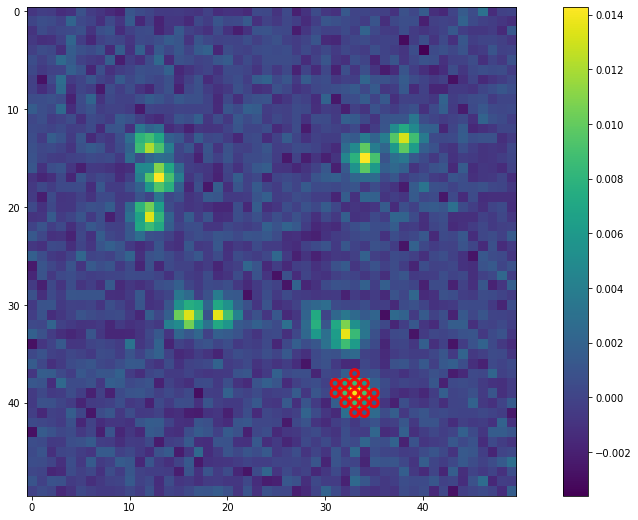

[132, 136, 131, 128, 133, 127, 137, 135, 129, 130, 134, 126, 139, 140, 138, 125]
Aperture: CircularAperture
positions: [[33., 39.],
            [33., 40.],
            [32., 39.],
            [33., 38.],
            [34., 39.],
            [32., 38.],
            [34., 40.],
            [32., 40.],
            [34., 38.],
            [31., 39.],
            [35., 39.],
            [31., 38.],
            [33., 41.],
            [34., 41.],
            [35., 40.],
            [33., 37.]]
r: 0.4
16


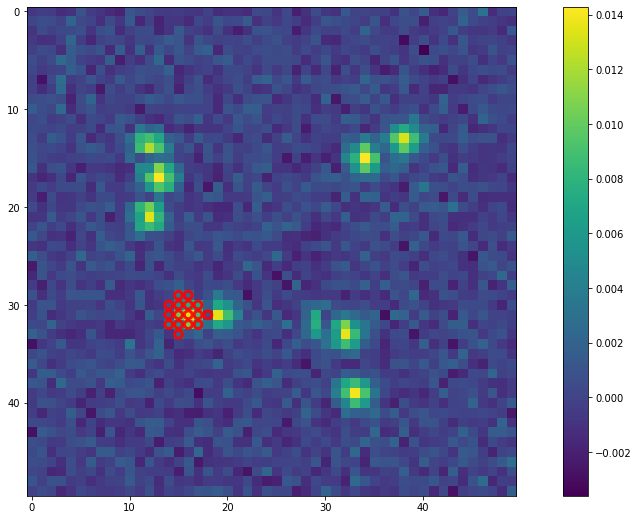

[86, 78, 87, 88, 99, 100, 80, 101, 79, 98, 74, 113, 85, 75, 77, 89]
Aperture: CircularAperture
positions: [[15., 31.],
            [15., 30.],
            [16., 31.],
            [17., 31.],
            [15., 32.],
            [16., 32.],
            [17., 30.],
            [17., 32.],
            [16., 30.],
            [14., 32.],
            [15., 29.],
            [15., 33.],
            [14., 31.],
            [16., 29.],
            [14., 30.],
            [18., 31.]]
r: 0.4
16


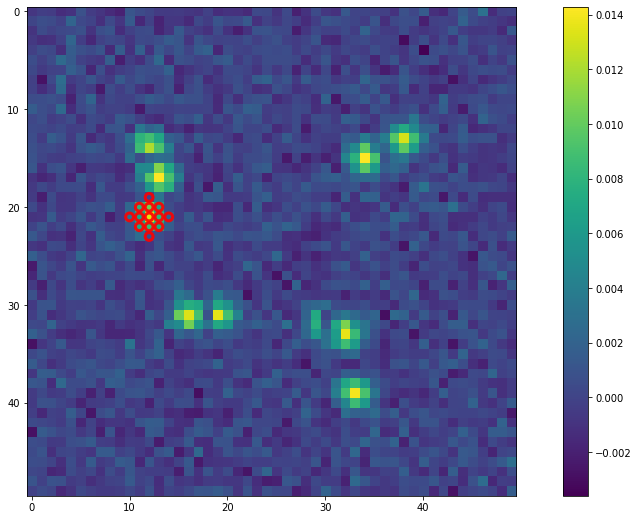

[71, 72, 70, 67, 68, 63, 66, 62, 64, 65, 69, 73, 60]
Aperture: CircularAperture
positions: [[12., 22.],
            [13., 22.],
            [11., 22.],
            [12., 21.],
            [13., 21.],
            [12., 20.],
            [11., 21.],
            [11., 20.],
            [13., 20.],
            [10., 21.],
            [14., 21.],
            [12., 23.],
            [12., 19.]]
r: 0.4
13


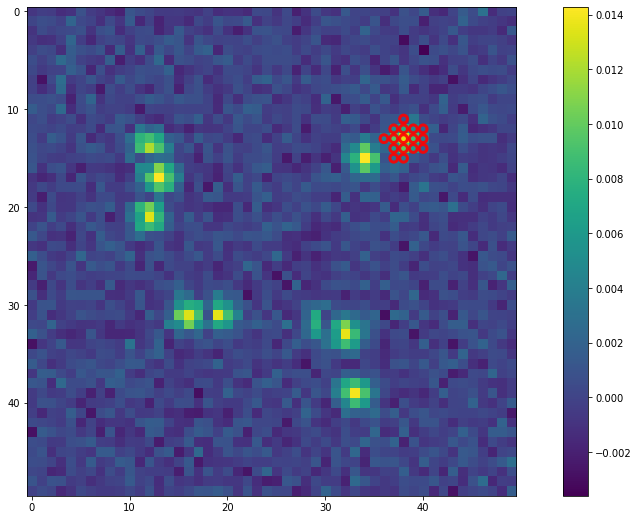

[17, 16, 30, 29, 5, 4, 15, 28, 18, 3, 14, 42, 6, 41, 31, 0]
Aperture: CircularAperture
positions: [[39., 13.],
            [38., 13.],
            [39., 14.],
            [38., 14.],
            [39., 12.],
            [38., 12.],
            [37., 13.],
            [37., 14.],
            [40., 13.],
            [37., 12.],
            [36., 13.],
            [38., 15.],
            [40., 12.],
            [37., 15.],
            [40., 14.],
            [38., 11.]]
r: 0.4
16


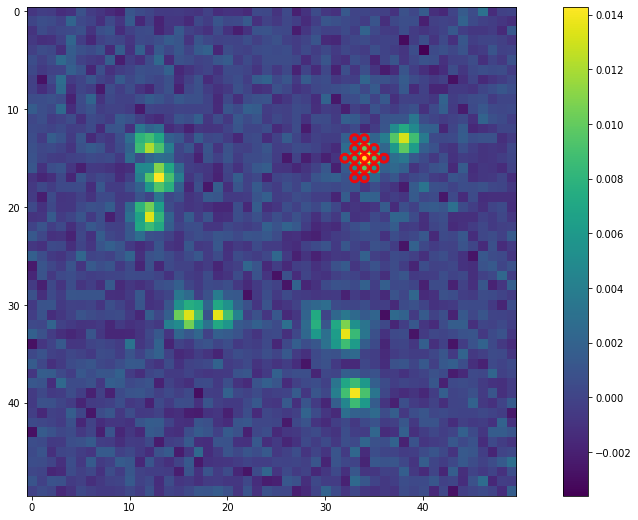

[37, 38, 25, 24, 48, 47, 39, 36, 49, 26, 13, 55, 54, 12, 40]
Aperture: CircularAperture
positions: [[33., 15.],
            [34., 15.],
            [34., 14.],
            [33., 14.],
            [34., 16.],
            [33., 16.],
            [35., 15.],
            [32., 15.],
            [35., 16.],
            [35., 14.],
            [34., 13.],
            [34., 17.],
            [33., 17.],
            [33., 13.],
            [36., 15.]]
r: 0.4
15


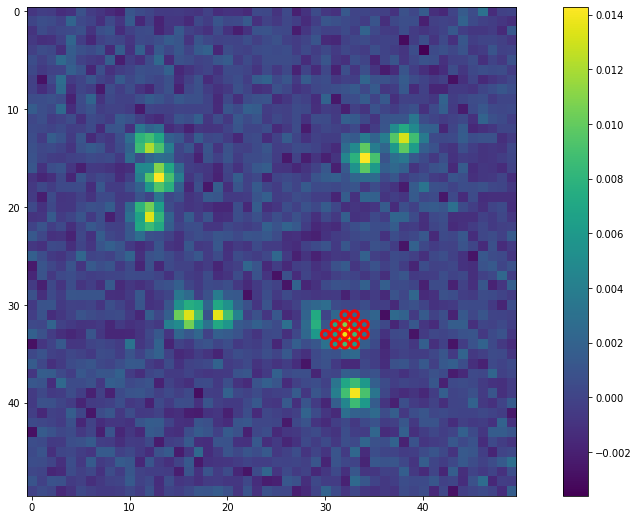

[119, 118, 109, 110, 117, 124, 123, 111, 122, 120, 112, 96, 116, 97]
Aperture: CircularAperture
positions: [[33., 33.],
            [32., 33.],
            [31., 32.],
            [32., 32.],
            [31., 33.],
            [33., 34.],
            [32., 34.],
            [33., 32.],
            [31., 34.],
            [34., 33.],
            [34., 32.],
            [32., 31.],
            [30., 33.],
            [33., 31.]]
r: 0.4
14


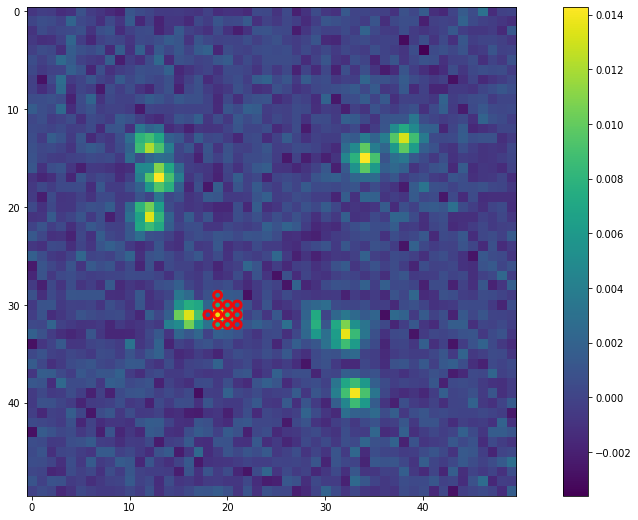

[92, 90, 91, 104, 83, 84, 103, 82, 105, 76, 89]
Aperture: CircularAperture
positions: [[21., 31.],
            [19., 31.],
            [20., 31.],
            [20., 32.],
            [20., 30.],
            [21., 30.],
            [19., 32.],
            [19., 30.],
            [21., 32.],
            [19., 29.],
            [18., 31.]]
r: 0.4
11


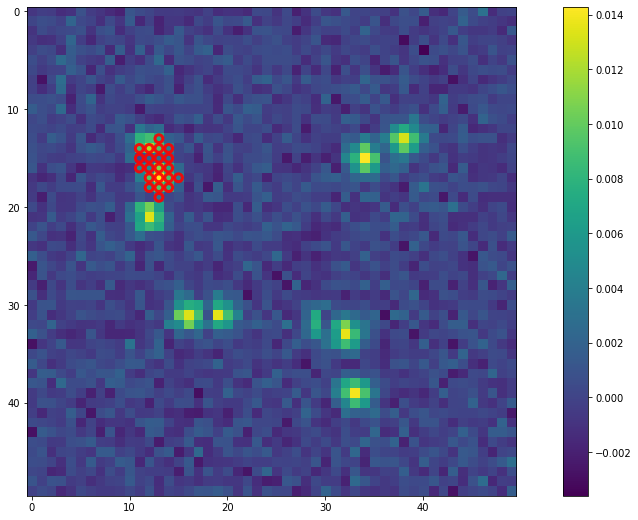

[45, 51, 21, 57, 22, 50, 10, 46, 52, 58, 20, 44, 56, 43, 34, 53, 61, 23, 33, 35, 32]
Aperture: CircularAperture
positions: [[13., 16.],
            [13., 17.],
            [12., 14.],
            [13., 18.],
            [13., 14.],
            [12., 17.],
            [13., 13.],
            [14., 16.],
            [14., 17.],
            [14., 18.],
            [11., 14.],
            [12., 16.],
            [12., 18.],
            [11., 16.],
            [13., 15.],
            [15., 17.],
            [13., 19.],
            [14., 14.],
            [12., 15.],
            [14., 15.],
            [11., 15.]]
r: 0.4
21


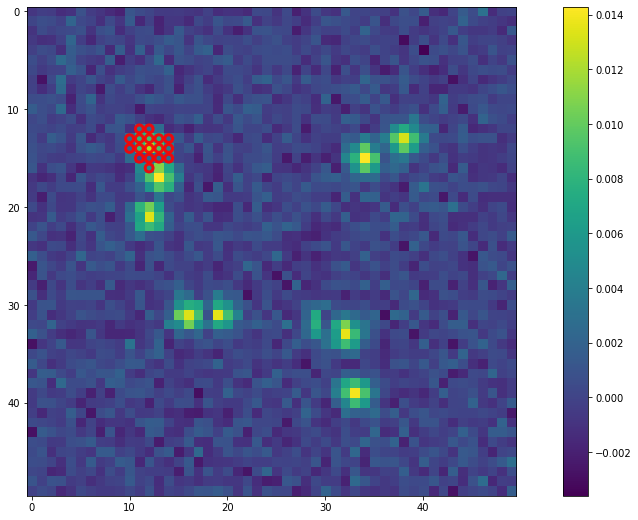

[21, 9, 1, 8, 22, 10, 20, 2, 44, 34, 23, 7, 33, 35, 11, 19, 32]
Aperture: CircularAperture
positions: [[12., 14.],
            [12., 13.],
            [11., 12.],
            [11., 13.],
            [13., 14.],
            [13., 13.],
            [11., 14.],
            [12., 12.],
            [12., 16.],
            [13., 15.],
            [14., 14.],
            [10., 13.],
            [12., 15.],
            [14., 15.],
            [14., 13.],
            [10., 14.],
            [11., 15.]]
r: 0.4
17


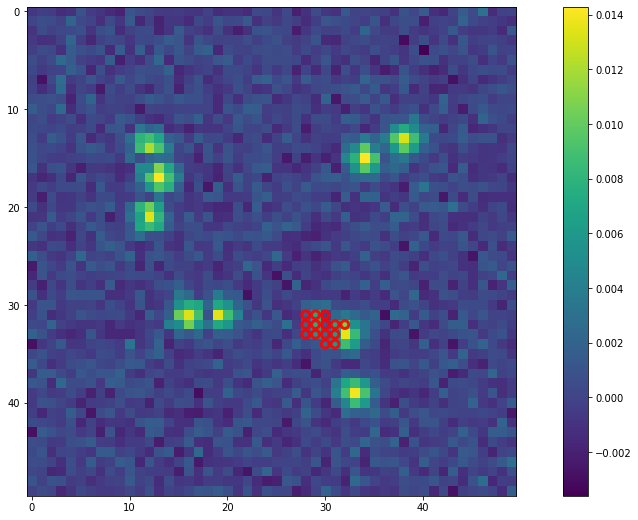

[109, 110, 117, 122, 107, 94, 115, 116, 121, 106, 114, 93, 108, 95]
Aperture: CircularAperture
positions: [[31., 32.],
            [32., 32.],
            [31., 33.],
            [31., 34.],
            [29., 32.],
            [29., 31.],
            [29., 33.],
            [30., 33.],
            [30., 34.],
            [28., 32.],
            [28., 33.],
            [28., 31.],
            [30., 32.],
            [30., 31.]]
r: 0.4
14


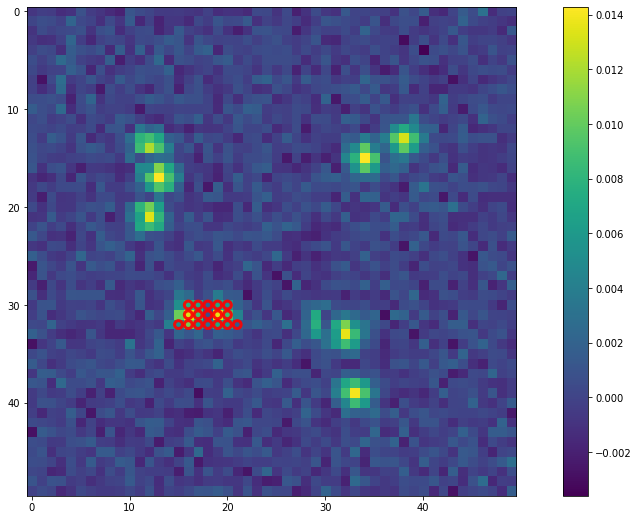

[87, 88, 90, 99, 91, 100, 80, 101, 79, 104, 83, 103, 82, 102, 105, 81, 89]
Aperture: CircularAperture
positions: [[16., 31.],
            [17., 31.],
            [19., 31.],
            [15., 32.],
            [20., 31.],
            [16., 32.],
            [17., 30.],
            [17., 32.],
            [16., 30.],
            [20., 32.],
            [20., 30.],
            [19., 32.],
            [19., 30.],
            [18., 32.],
            [21., 32.],
            [18., 30.],
            [18., 31.]]
r: 0.4
17


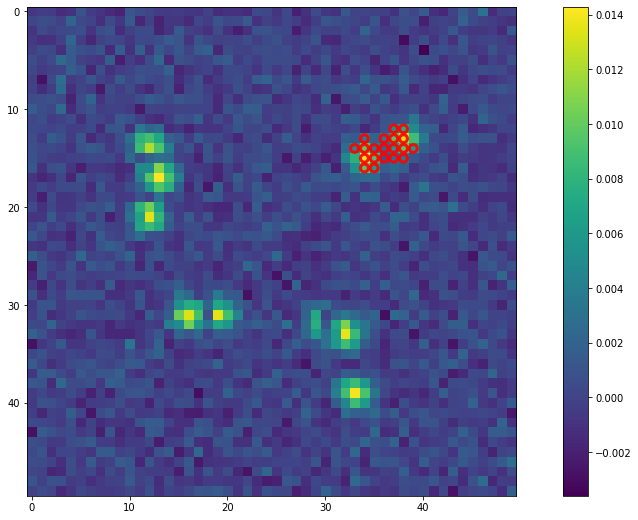

[16, 38, 30, 29, 25, 24, 48, 4, 39, 15, 49, 28, 3, 14, 42, 26, 13, 27, 41, 40]
Aperture: CircularAperture
positions: [[38., 13.],
            [34., 15.],
            [39., 14.],
            [38., 14.],
            [34., 14.],
            [33., 14.],
            [34., 16.],
            [38., 12.],
            [35., 15.],
            [37., 13.],
            [35., 16.],
            [37., 14.],
            [37., 12.],
            [36., 13.],
            [38., 15.],
            [35., 14.],
            [34., 13.],
            [36., 14.],
            [37., 15.],
            [36., 15.]]
r: 0.4
20


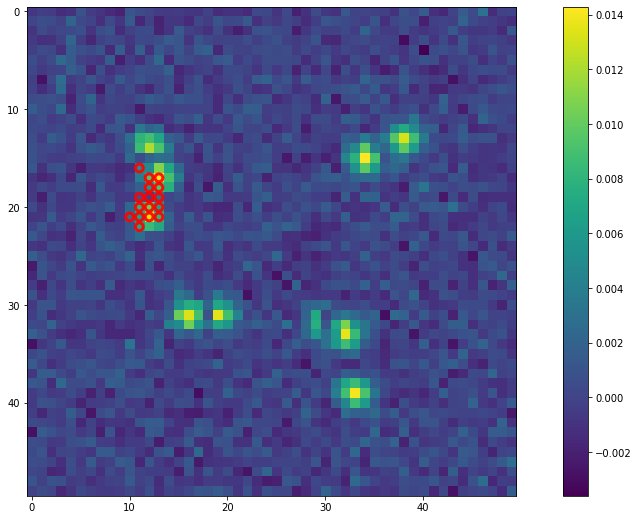

[70, 67, 51, 68, 57, 63, 66, 50, 62, 56, 64, 43, 65, 61, 59, 60]
Aperture: CircularAperture
positions: [[11., 22.],
            [12., 21.],
            [13., 17.],
            [13., 21.],
            [13., 18.],
            [12., 20.],
            [11., 21.],
            [12., 17.],
            [11., 20.],
            [12., 18.],
            [13., 20.],
            [11., 16.],
            [10., 21.],
            [13., 19.],
            [11., 19.],
            [12., 19.]]
r: 0.4
16


In [190]:




for k in range(0,len(all_agglomerations_index)):
    sources_upper=CircularAperture(np.transpose((table['horizontal coor'][all_agglomerations_index[k]],table['vertical coor'][all_agglomerations_index[k]])), r=0.4)

    plt.figure(figsize=[17, 9])
    plt.imshow(rectmap)
    plt.colorbar()    
    sources_upper.plot(color='red', lw=3, alpha=0.9)
    plt.show(block=False)
    print(all_agglomerations_index[k])
    print(sources_upper)
    print(len(all_agglomerations_index[k]))





In [191]:

horizontal_barycenter_list=[]
vertical_barycenter_list=[]
for i in range(0,len(all_agglomerations_index)):
    deno = np.sum(table['Amplitude [K]'][all_agglomerations_index[i]])
    horizontal_barycenter = np.sum( table['horizontal coor'][all_agglomerations_index[i]] * table['Amplitude [K]'][all_agglomerations_index[i]] ) / deno
    vertical_barycenter = np.sum( table['vertical coor'][all_agglomerations_index[i]] * table['Amplitude [K]'][all_agglomerations_index[i]] ) / deno
    horizontal_barycenter_list.append(horizontal_barycenter)
    vertical_barycenter_list.append(vertical_barycenter)

barycenter_list=np.transpose((np.round(vertical_barycenter_list,1).astype(int),np.round(horizontal_barycenter_list,1).astype(int) ))
barycenter_list





array([[39, 33],
       [31, 15],
       [21, 12],
       [13, 38],
       [15, 33],
       [32, 32],
       [30, 19],
       [16, 12],
       [13, 12],
       [32, 30],
       [31, 17],
       [14, 36],
       [19, 12]])

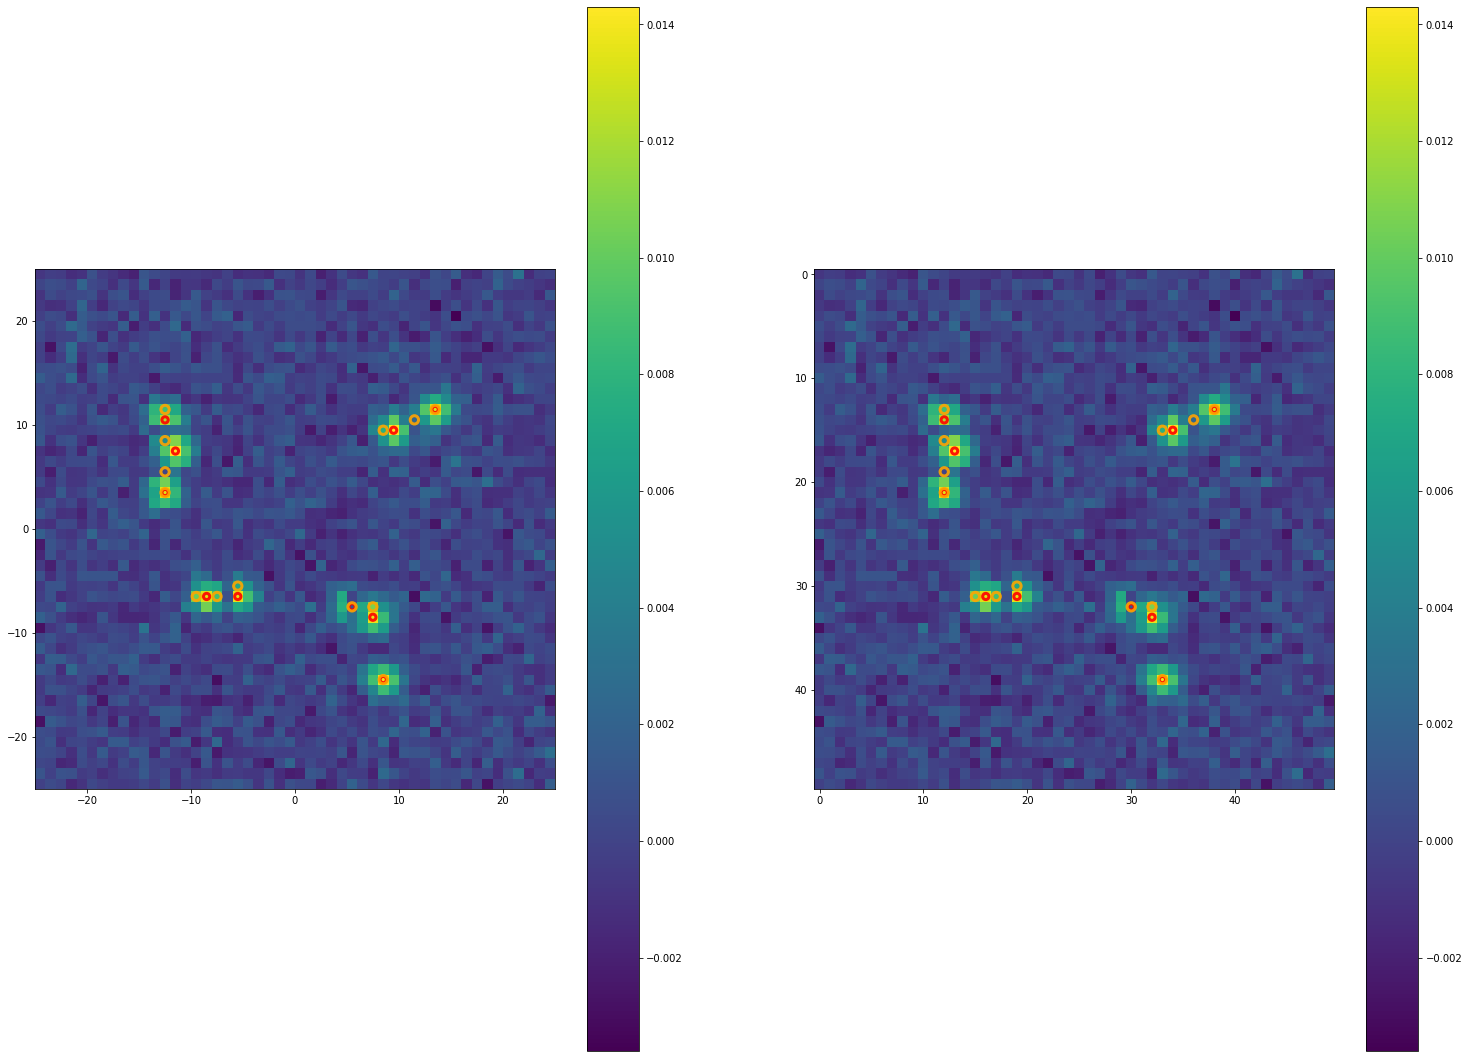

In [194]:
bar_center=convert_map_index.convert_upper_to_center([barycenter_list[:,0],barycenter_list[:,1]],np.shape(rectmap)[0],len(barycenter_list[0]))[4]

barycenter_center=CircularAperture(bar_center, r=0.4)
barycenter_upper=CircularAperture(np.transpose((barycenter_list[:,1],barycenter_list[:,0])), r=0.4)


    
plt.figure(figsize=[25.6, 19.2])

plt.subplot(121)
plt.imshow(rectmap,extent=(-np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2, -np.shape(rectmap)[0]/2, np.shape(rectmap)[0]/2))
plt.colorbar()    
simulated_src_center.plot(color='red', lw=3, alpha=0.9)
barycenter_center.plot(color='orange', lw=3, alpha=0.9)


plt.subplot(122)
plt.imshow(rectmap)    
plt.colorbar()
simulated_src_upper.plot(color='red', lw=3, alpha=0.9)
barycenter_upper.plot(color='orange', lw=3, alpha=0.9)


plt.show(block=False)

### Computing fluxes

In [195]:
flux_integration_kernel=np.ones((detection_kernels_size[2],detection_kernels_size[2]))
flux_map=nd.convolve(rectmap,flux_integration_kernel)-(detection_kernels_size[2]**2)*conv_maps[3]  # what to do with negative median - use farer and thiner ring
#coor=np.transpose((barycenter_list[0],barycenter_list[1]))
coor=( barycenter_list[:,1] , barycenter_list[:,0] )
flux_list_k=flux_map[coor]
flux_list_jansky=k2jansky.k2jansky('freq',1300*10**6,16.5,1,flux_list_k)


flux_list=(flux_list_k,flux_list_jansky)
flux_list

     

(array([-0.00777226,  0.0509437 , -0.00049625, -0.00212628,  0.07839276,
         0.10299025,  0.01344008,  0.00835923,  0.04507704,  0.07507496,
         0.0524271 , -0.01311539, -0.00654311]),
 array([-0.07883021,  0.51669689, -0.00503317, -0.02156584,  0.79509923,
         1.04457955,  0.13631608,  0.08478358,  0.45719425,  0.7614484 ,
         0.53174236, -0.13302294, -0.06636357]))

### Three cartesian coordinate system

In [196]:
import convert_map_index

simulated_coor_center=convert_map_index.convert_upper_to_center( [ simulated_catalog[:,0],simulated_catalog[:,1] ] , np.shape(rectmap)[0],len(simulated_catalog[:,0]) )[4]
coor_center=convert_map_index.convert_upper_to_center([table['vertical coor'],table['horizontal coor']],np.shape(rectmap)[0],len(table['vertical coor']))[4]
bar_center=convert_map_index.convert_upper_to_center([barycenter_list[:,1],barycenter_list[:,0]],np.shape(rectmap)[0],len(barycenter_list[0]))[4]



In [198]:

def convert_upper_to_center(srccoor_upper_pixcorner,sizef,lenght):
    srccoor_upper_pixcenter=srccoor_upper_pixcorner+np.full((2,np.shape(srccoor_upper_pixcorner)[1]),0.5)
    srccoor_lower_pixcenter=[srccoor_upper_pixcenter[0],sizef-srccoor_upper_pixcenter[1]]
    srccoor_center_pixcenter=srccoor_lower_pixcenter+np.full(np.shape(srccoor_upper_pixcenter),-sizef/2)
    transpose_srccoor_center_pixcenter=np.transpose((-srccoor_center_pixcenter[1],-srccoor_center_pixcenter[0]))
    return [srccoor_upper_pixcorner,srccoor_upper_pixcenter,srccoor_lower_pixcenter,srccoor_center_pixcenter,transpose_srccoor_center_pixcenter]


def convert_center_to_upper(transpose_srccoor_center_pixcenter,sizef,lenght):
    #transpose_srccoor_center_pixcenter=np.transpose((np.zeros(sizef),np.zeros(sizef))
    srccoor_center_pixcenter=np.zeros((2,lenght))
    srccoor_center_pixcenter[1]=-transpose_srccoor_center_pixcenter[:,0]
    srccoor_center_pixcenter[0]=-transpose_srccoor_center_pixcenter[:,1]
    srccoor_lower_pixcenter=srccoor_center_pixcenter- np.full(lenght,-sizef/2)
    srccoor_upper_pixcenter=np.zeros((2,lenght))
    srccoor_upper_pixcenter[0]=srccoor_lower_pixcenter[0]
    srccoor_upper_pixcenter[1]=sizef-srccoor_lower_pixcenter[1]
    transpose_srccoor_upper_pixcenter=np.transpose((srccoor_upper_pixcenter[0],srccoor_upper_pixcenter[1]))
    srccoor_upper_pixcorner=srccoor_upper_pixcenter - np.full((2,lenght),0.5)
    transpose_srccoor_upper_pixcorner=np.transpose((srccoor_upper_pixcorner[0],srccoor_upper_pixcorner[1]))
    transpose_srccoor_upper_pixcenter=np.int_(transpose_srccoor_upper_pixcenter)
    return transpose_srccoor_upper_pixcenter

### World coordinate

In [199]:
import pixel2world
projection_center=(90,180)
map_resolution=18

barycenter_list_world=pixel2world.pixel2world(projection_center,map_resolution,bar_center)
simulated_src_world=pixel2world.pixel2world(projection_center,map_resolution,simulated_coor_center)


### Detected sources catalog

In [201]:
final_catalog=np.transpose((barycenter_list_world[:,0],barycenter_list_world[:,1],flux_list[1]))
dd=np.argsort(final_catalog[:,0])
final_catalog=final_catalog[dd]
final_catalog=np.column_stack( ( range(0,len(final_catalog)) , final_catalog ))

import pandas as pd

detection_dataframe=pd.DataFrame(final_catalog,columns=['index','dec[deg]','ra[deg]','flux[Jy]'])
detection_dataframe


,index,dec[deg],ra[deg],flux[Jy]
0,0.0,-88.350456,1.648861,0.136316
1,1.0,-88.050752,2.846008,0.516697
2,2.0,-88.050752,2.247545,0.531742
3,3.0,-87.751156,-2.247114,1.044580
4,4.0,-87.751156,-1.648274,0.761448
5,5.0,-85.658329,-2.541015,-0.078830
6,6.0,266.554161,-4.035989,-0.021566
7,7.0,266.554161,3.737908,0.457194
8,8.0,266.853168,-3.440656,-0.133023
9,9.0,267.152347,-2.545176,0.795099


### Simulated sources catalog

In [202]:
simulated_final_catalog=np.transpose((simulated_src_world[:,0],simulated_src_world[:,1],simulated_catalog[:,2]))
ff=np.argsort(simulated_final_catalog[:,0])
simulated_final_catalog=simulated_final_catalog[ff]
simulated_final_catalog=np.column_stack( ( range(0,len(simulated_final_catalog)) , simulated_final_catalog ))

simulated_final_catalog

simulation_dataframe=pd.DataFrame(simulated_final_catalog,columns=['index','dec[deg]','ra[deg]','flux[Jy]'])
simulation_dataframe


,index,dec[deg],ra[deg],flux[Jy]
0,0.0,-88.350456,-2.247914,1.0
1,1.0,-87.751156,-2.546358,1.0
2,2.0,-87.451682,-4.337394,1.0
3,3.0,-87.152347,2.844142,1.0
4,4.0,-85.956725,3.437284,1.0
5,5.0,266.255341,1.047641,1.0
6,6.0,266.255341,3.140127,1.0
7,7.0,266.554161,2.244783,1.0
8,8.0,267.451682,-1.947321,1.0
9,9.0,268.350456,-1.948440,1.0


Plot

## Object oriented version